a)

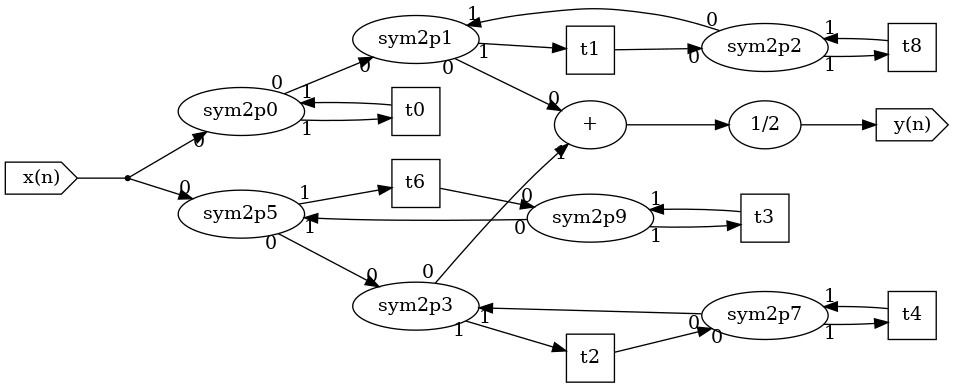

In [14]:
from b_asic.core_operations import Addition, ConstantMultiplication
from b_asic.signal_flow_graph import SFG
from b_asic.special_operations import Delay, Input, Output
from b_asic.sfg_generators import wdf_allpass

a0 = 167/256
a1 = -135/256
a2 = 1663/2048
a3 = -1493/2048
a4 = 669/1024
a5 = -117/128
a6 = 583/1024

x = Input()
x.graph_id = "x(n)"

allpass_upper = wdf_allpass([a0, a3, a4]) 
allpass_lower = wdf_allpass([a1, a2, a5, a6])

allpass_upper <<= x
allpass_lower <<= x

add0 = allpass_upper + allpass_lower
add0.graph_id = "+"
c0 = ConstantMultiplication(0.5, add0)
c0.graph_id = "1/2"
y = Output(c0)
y.graph_id = "y(n)"

allpass_upper.connect_external_signals_to_components()
allpass_lower.connect_external_signals_to_components()

sfg = SFG([x], [y])
sfg

b)

In [15]:
from b_asic.simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from b_asic.signal_generator import Impulse
from mplsignal.freq_plots import freqz_fir

sim = Simulation(sfg, [Impulse()])
sim.run_for(100)

print(np.sqrt(sum(sim.results["sym2p0.0"]**2)))
print(np.sqrt(sum(sim.results["sym2p1.0"]**2)))
print(np.sqrt(sum(sim.results["sym2p2.0"]**2)))
print(np.sqrt(sum(sim.results["sym2p3.0"]**2)))
print(np.sqrt(sum(sim.results["sym2p5.0"]**2)))
print(np.sqrt(sum(sim.results["sym2p7.0"]**2)))
print(np.sqrt(sum(sim.results["sym2p9.0"]**2)))

1.0
0.9999999999999918
2.5259018548193746
0.9999852824751649
0.9999999999999998
4.7189767588294425
1.7976109030259262



Critical: sym2p2 (a4), sym2p7 (a6), sym2p9 (a3)

c)

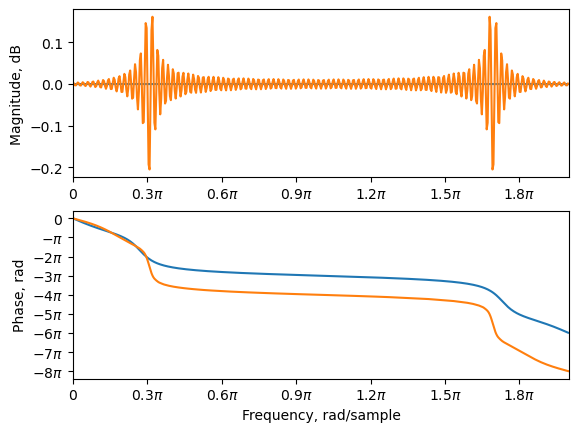

In [16]:
allpass_upper = wdf_allpass([a0, a3, a4]) 
allpass_lower = wdf_allpass([a1, a2, a5, a6])

sim_upper = Simulation(allpass_upper, [Impulse()])
sim_upper.run_for(100)
sim_lower = Simulation(allpass_lower, [Impulse()])
sim_lower.run_for(100)

freqz_fir(sim_upper.results["0"], whole=True)
fig = freqz_fir(sim_lower.results["0"], whole=True)

d)  
Difference in phase (guess of where, how to see?),  
Passband: ~Pi  
Stopband: ~2*Pi  

e)

Critical: sym2p2 (a4), sym2p7 (a6), sym2p9 (a3)

In [17]:
## Critical: sym2p2 (a4), sym2p7 (a6), sym2p9 (a3)
#c1 = ConstantMultiplication(2**(-3))
#c2 = ConstantMultiplication(2**3)
#c1.graph_id = "c1"
#c2.graph_id = "c2"
#
#c3 = ConstantMultiplication(2**(-2))
#c4 = ConstantMultiplication(2**2)
#c3.graph_id = "c3"
#c4.graph_id = "c4"
#
##allpass_upper = allpass_upper.insert_operation_before("sym2p0", c3)
## If the above is added then two constants multiplications are added to the graph
## though it's expected that only should.
#allpass_upper = allpass_upper.insert_operation_after("sym2p1.0", c4)
#allpass_upper
##sfg_new

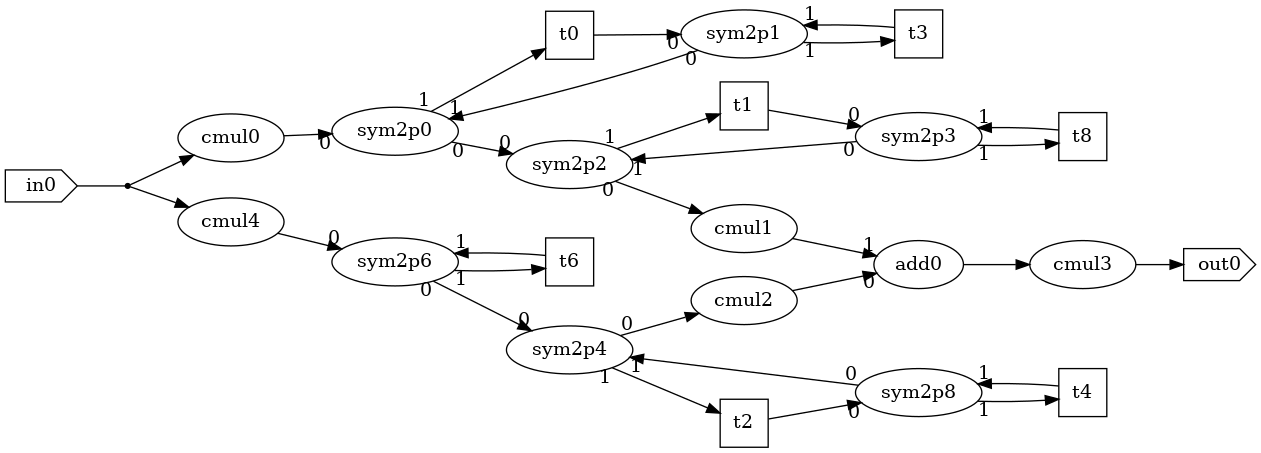

In [18]:
new_x = Input()

new_allpass_upper = wdf_allpass([a0, a3, a4]) 
new_allpass_lower = wdf_allpass([a1, a2, a5, a6])

new_c1 = ConstantMultiplication(2**(-2), new_x)
new_c2 = ConstantMultiplication(2**2, new_allpass_lower)

new_c3 = ConstantMultiplication(2**(-2), new_x)
new_c4 = ConstantMultiplication(2**2, new_allpass_upper)

new_allpass_upper <<= new_c3
new_allpass_lower <<= new_c1

new_add0 = new_c4 + new_c2
new_c0 = ConstantMultiplication(0.5, new_add0)
new_y = Output(new_c0)

new_allpass_upper.connect_external_signals_to_components()
new_allpass_lower.connect_external_signals_to_components()

new_sfg = SFG([new_x], [new_y])
new_sfg

f)

In [19]:
new_sim = Simulation(new_sfg, [Impulse()])
new_sim.run_for(100)

print(np.sqrt(sum(new_sim.results["sym2p0.0"]**2)))
print(np.sqrt(sum(new_sim.results["sym2p1.0"]**2)))
print(np.sqrt(sum(new_sim.results["sym2p2.0"]**2)))
print(np.sqrt(sum(new_sim.results["sym2p3.0"]**2)))
print(np.sqrt(sum(new_sim.results["sym2p6.0"]**2)))
print(np.sqrt(sum(new_sim.results["sym2p4.0"]**2)))
print(np.sqrt(sum(new_sim.results["sym2p8.0"]**2)))

0.24999999999999994
0.44940272575648155
0.24999632061879123
1.1797441897073606
0.25
0.24999999999999795
0.6314754637048436


Has the function changed? We compare the impulse responses of the the old simulation (old SFG) and new one.

<StemContainer object of 3 artists>

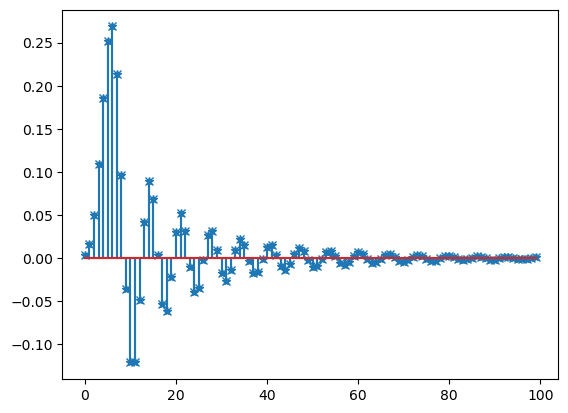

In [20]:
fig, ax = plt.subplots()
ax.stem(sim.results["0"],markerfmt="*")
ax.stem(new_sim.results["0"],markerfmt="x")

The functionality looks the same for an impulse response, that shouldn't be the case? But the from earlier we have that the output has changed, so something has changed...

g) Simulate the scaled filter with a random input. Comments? Can overflow occur in any node? 

<StemContainer object of 3 artists>

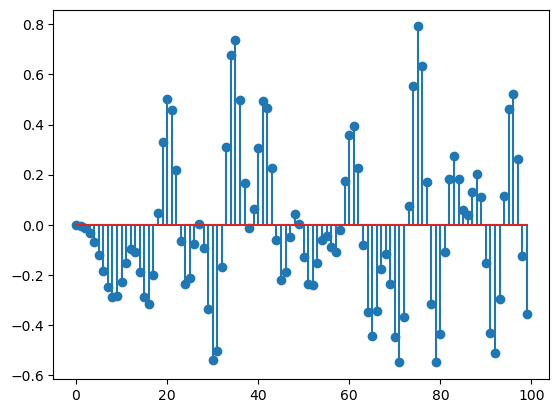

In [21]:
data = np.random.rand(100)*2 - 1
rand_sim = Simulation(new_sfg, [data])
rand_sim.run_for(100)

fig, ax = plt.subplots()
ax.stem(rand_sim.results["0"])

Overflow possible!

h) Introduce a pipelining delay in each branch and compare the output with the non-pipelined SFG. Comments? 

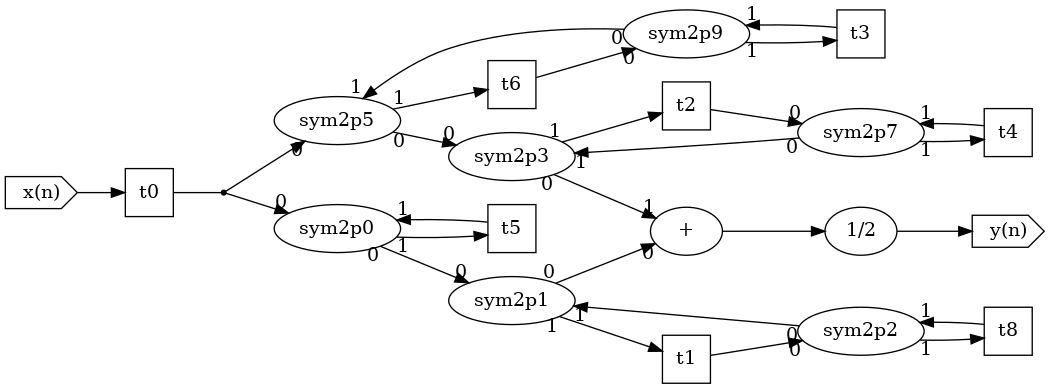

In [22]:
pipelined_sfg = sfg.insert_operation_after("x(n)", Delay())
pipelined_sfg

<StemContainer object of 3 artists>

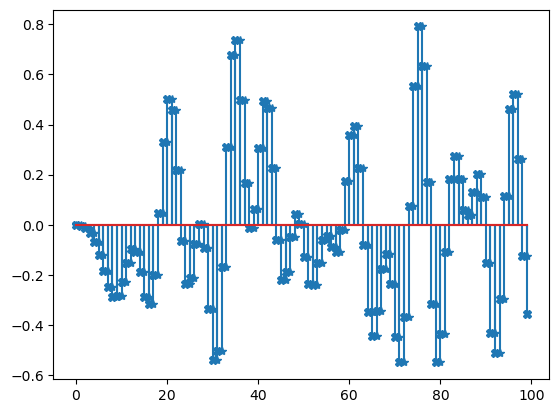

In [23]:
pipelined_sim = Simulation(pipelined_sfg, [data])
pipelined_sim.run_for(100)

fig, ax = plt.subplots()
ax.stem(rand_sim.results["0"], markerfmt="X")
ax.stem(pipelined_sim.results["0"], markerfmt="*")

No change?

i) Plot the precedence graph for the pipelined SFG.  

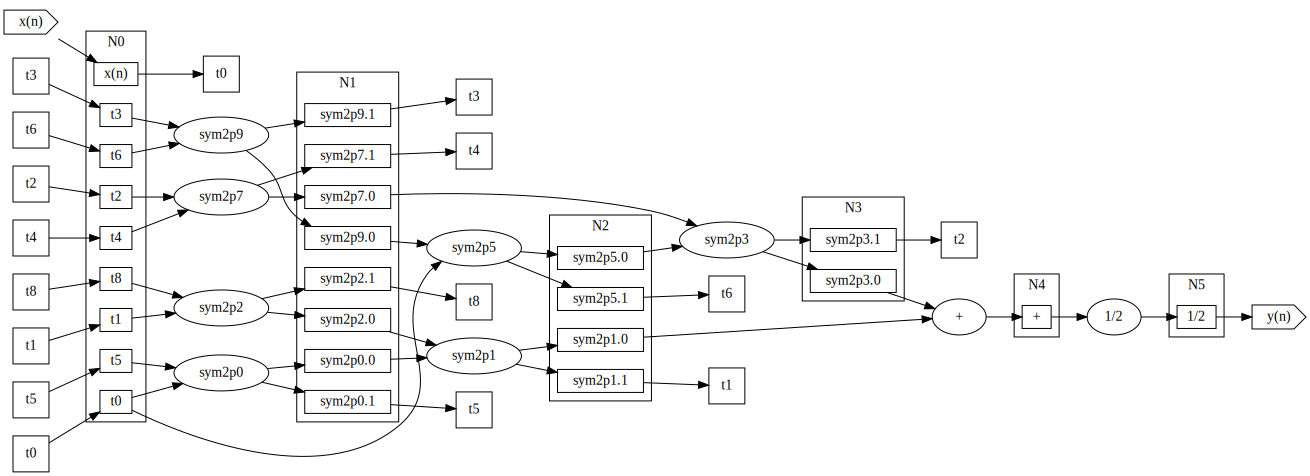

In [24]:
pipelined_sfg.precedence_graph